In [1]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import torch
from jax import random, grad, vmap, jit, hessian, value_and_grad
from jax.experimental import optimizers
from jax.experimental.optimizers import adam, exponential_decay
from jax.experimental.ode import odeint
from jax.nn import relu, elu, softplus
from jax.config import config
from jax.ops import index_update, index
from jax import lax
from jax.lax import while_loop, scan, cond
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import scipy
import scipy.io
from scipy.io import loadmat

import sys
sys.path.append('../DeepONetsPI/')  # add the pde package to the python path

from layers import MLP, modified_MLP, FF_MLP
from model import DeepONetPI
from utils import RBF
from DataGenerator import DataGenerator

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Burgers Equation
$$
\frac{\partial s}{\partial t}+s \frac{\partial s}{\partial x} - \nu \frac{\partial^{2} s}{\partial x^{2}}=0, \quad x \in(0,1), t \in(0,1], \\
s(x, 0) = u(x), \\
s(0, t) = s(1, t), \\
\frac{\partial s}{\partial x}(0, t) = \frac{\partial s}{\partial x}(1, t), \\
\nu = 0.01
$$

In [2]:
class BurgerDeepONetPI(DeepONetPI):
    def __init__(self,
                 branch_layers, 
                 trunk_layers, 
                 branch_net=MLP,
                 trunk_net=MLP,
                 branch_activation=jnp.tanh,
                 trunk_activation=jnp.tanh,
                 branch_rng_key=random.PRNGKey(1234),
                 trunk_rng_key=random.PRNGKey(4321),
                 optimizer=adam(exponential_decay(1e-3, decay_steps=2000, decay_rate=0.9)),
                 operator_loss_const=1.0,
                 physics_loss_const=1.0,
                 bcs_loss_const=1.0,
                 ics_loss_const=1.0,
                 ckpt_dir='Burger',
                 ckpt_file='params.npy',
                 loss_file='loss.npy',
                 loss_operator_file='loss_operator.npy',
                 loss_physics_file='loss_physics.npy',
                 loss_bcs_file='loss_bcs.npy',
                 loss_ics_file='loss_ics.npy',   
                 ):
        super().__init__(branch_layers, 
                         trunk_layers, 
                         branch_net, 
                         trunk_net, 
                         branch_activation, 
                         trunk_activation, 
                         branch_rng_key, 
                         trunk_rng_key, 
                         optimizer, 
                         operator_loss_const, 
                         physics_loss_const, 
                         bcs_loss_const, 
                         ics_loss_const, 
                         ckpt_dir, 
                         ckpt_file, 
                         loss_file, 
                         loss_operator_file, 
                         loss_physics_file, 
                         loss_bcs_file, 
                         loss_ics_file)
        
    def pde_net(self, params, u, y):
        # note that y here can include additional coord not passed to the original operator network
        # print(y.shape)
        x = y[0]
        t = y[1]
        s_ = self.operator_net # shorthand for operator_net function call
        s = s_(params, u, x, t) # actual value of s (may not be needed)
        s_x = grad(s_, 2)(params, u, x, t) 
        s_t = grad(s_, 3)(params, u, x, t)
        s_xx = grad(grad(s_, 2), 2)(params, u, x, t)
        res = s_t + s * s_x - 0.01 * s_xx # this is equal to u(x), this avoids the interpolation
        return res
    
    # here we are provided with values for BC/IC (zero), so for this case just call the operator net.  If we had Robin BC for example, we would output an array with outputs of [value, derivative]
    # Also, if we had the case where BC/IC = u, we would return res = s - u
    def bc_net(self, params, u, y):
        s_ = self.operator_net # shorthand for operator_net function call
        # s = s_(params, u, y) # actual value of s
        # bc1 is at x = 0, bc2 is at x = 1
        y_bc1 = y[0:2]
        y_bc2 = y[2:]
        x_bc1 = y_bc1[0]
        t_bc1 = y_bc1[1]
        x_bc2 = y_bc2[0]
        t_bc2 = y_bc2[1]
        s_bc1, s_x_bc1 = value_and_grad(s_, 2)(params, u, x_bc1, t_bc1)
        s_bc2, s_x_bc2 = value_and_grad(s_, 2)(params, u, x_bc2, t_bc2)
        res_s = jnp.mean((s_bc1 - s_bc2)**2)
        res_s_x = jnp.mean((s_x_bc1 - s_x_bc2)**2)
        res = res_s + res_s_x
        return res
    
    def ic_net(self, params, u, y):
        s_ = self.operator_net # shorthand for operator_net function call
        s = s_(params, u, y) # actual value of s
        return s


In [3]:
# Geneate operator training data corresponding to one input sample
def generate_one_op_training_data(key, u, y, s, N_op=1000):
    x = y[:, 0]
    t = y[:, 1]
    Nx = len(x)
    Nt = len(t)
    idx = random.randint(key, (N_op, 2), 0, max(Nx, Nt))
    u_op = jnp.tile(u, (N_op, 1))
    y_op = jnp.hstack((x[idx[:,0]][:, None], t[idx[:,1]][:, None]))
    s_op = s[idx[:,0], idx[:,1]]
    return u_op, y_op, s_op

# Geneate res training data corresponding to one input sample
def generate_one_pde_training_data(key, u0, N_pde=1000):

    subkeys = random.split(key, 2)
   
    t_pde = random.uniform(subkeys[0], (N_pde,1))
    x_pde = random.uniform(subkeys[1], (N_pde,1))

    u = jnp.tile(u0, (N_pde, 1))
    y =  jnp.hstack([x_pde, t_pde])
    s = jnp.zeros((N_pde, 1))

    return u, y, s
# Geneate bcs training data corresponding to one input sample
def generate_one_bcs_training_data(key, u0, N_bcs=100):

    t_bc = random.uniform(key, (N_bcs,1))
    x_bc1 = jnp.zeros((N_bcs, 1))
    x_bc2 = jnp.ones((N_bcs, 1))
  
    y1 = jnp.hstack([x_bc1, t_bc])  # shape = (N_bcs, 2)
    y2 = jnp.hstack([x_bc2, t_bc])  # shape = (N_bcs, 2)

    u = jnp.tile(u0, (N_bcs, 1))
    y =  jnp.hstack([y1, y2])  # shape = (N_bcs, 4)
    s = jnp.zeros((N_bcs, 1))

    return u, y, s

# Geneate ics training data corresponding to one input sample
def generate_one_ics_training_data(key, u0, N_ics=101):

    t0 = jnp.zeros((N_ics,1))
    x0 = jnp.linspace(0, 1, N_ics)[:, None]

    y = jnp.hstack([x0, t0])
    u = jnp.tile(u0, (N_ics, 1))
    s = u0

    return u, y, s


# Geneate test data corresponding to one input sample
def generate_one_test_data(key, S, Nx=101, Nt=101):

#     s = S[key]
    u0 = S[:, 0]

    t = jnp.linspace(0, 1, Nt)
    x = jnp.linspace(0, 1, Nx)
    X, T = jnp.meshgrid(x, t)

    s = S.T.flatten()
    u = jnp.tile(u0, (Nx*Nt, 1))
    y = jnp.hstack([X.flatten()[:,None], T.flatten()[:,None]])
#     print(f"s: {s.shape}") 
#     print(f"u: {u.shape}") 
#     print(f"y: {y.shape}") 
    return u, y, s 

# Geneate training data corresponding to N input sample
def compute_error(key, S, Nx=101, Nt=101):
    u_test, y_test, s_test = generate_one_test_data(key, S, Nx=101, Nt=101)
    
    u_test = u_test.reshape(Nx*Nt,-1)  
    y_test = y_test.reshape(Nx*Nt,-1)
    s_test = s_test.reshape(Nx*Nt,-1)

    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    error = jnp.linalg.norm(s_test - s_pred) / jnp.linalg.norm(s_test) 

    return error  

# Prepare the training data


In [4]:

# Load data
data_path = 'Data/Burger.mat'  # Please use the matlab script to generate data

data = loadmat(data_path)
U = jnp.array(data['input'])
S = jnp.array( data['output'])
S = jnp.swapaxes(S, 1, 2)

N = S.shape[0]  # number of total input samples
N_train = 900      # number of input samples used for training
N_test = N - N_train  # number of input samples used for test
m = 101            # number of sensors for input samples
Nx = m            # number of x coordinates (must be m for training as that is how we define the IC)
Nt = 101          # number of times (theoretically independent of m)
N_op_train = 1000 # number of locations for evaluating operater per sample
N_ics_train = m   # number of locations for evulating the initial condition
N_bcs_train = 100    # number of locations for evulating the boundary condition
N_pde_train = 2500   # number of locations for evulating the PDE residual
# N_test = 101        # resolution of uniform grid for the test data

x = jnp.linspace(0, 1, Nx)[:, None]
t = jnp.linspace(0, 1, Nt)[:, None]
U_train = U[:N_train]   # input samples
Y_train = jnp.hstack((x, t)) # coordinates (will always be the same)
S_train = S[:N_train]   # output samples

key = random.PRNGKey(0) # use different key for generating test data 
keys = random.split(key, N_train)


In [5]:
S.shape

(1000, 101, 101)

# Generate the Training Data

In [6]:
# Generate training data for operator
u_op_train, y_op_train, s_op_train = vmap(generate_one_op_training_data, (0, 0, None, 0, None))(keys, U_train, Y_train, S_train, N_op_train)

u_op_train = u_op_train.reshape(N_train * N_op_train, -1)  
y_op_train = y_op_train.reshape(N_train * N_op_train, -1)
s_op_train = s_op_train.reshape(N_train * N_op_train, -1)


# Generate training data for inital condition
u_ics_train, y_ics_train, s_ics_train = vmap(generate_one_ics_training_data, (0, 0, None))(keys, U_train, N_ics_train)

u_ics_train = u_ics_train.reshape(N_train * N_ics_train, -1)  
y_ics_train = y_ics_train.reshape(N_train * N_ics_train, -1)
s_ics_train = s_ics_train.reshape(N_train * N_ics_train, -1)

# Generate training data for boundary condition
u_bcs_train, y_bcs_train, s_bcs_train = vmap(generate_one_bcs_training_data, (0, 0, None))(keys, U_train, N_bcs_train)

u_bcs_train = u_bcs_train.reshape(N_train * N_bcs_train, -1)  
y_bcs_train = y_bcs_train.reshape(N_train * N_bcs_train, -1)
s_bcs_train = s_bcs_train.reshape(N_train * N_bcs_train, -1)

# Generate training data for PDE residual
u_pde_train, y_pde_train, s_pde_train = vmap(generate_one_pde_training_data, (0, 0, None))(keys, U_train, N_pde_train)

u_pde_train = u_pde_train.reshape(N_train * N_pde_train, -1)  
y_pde_train = y_pde_train.reshape(N_train * N_pde_train, -1)
s_pde_train = s_pde_train.reshape(N_train * N_pde_train, -1)

# Initialize model


In [7]:
branch_layers = [m, 100, 100, 100, 100, 100, 100, 100]
trunk_layers =  [2, 100, 100, 100, 100, 100, 100, 100]
model = BurgerDeepONetPI(branch_layers, trunk_layers, branch_net=modified_MLP, trunk_net=modified_MLP)

In [8]:
# Create data set
batch_size = 50000
op_dataset = DataGenerator(u_op_train, y_op_train, s_op_train, batch_size)
pde_dataset = DataGenerator(u_pde_train, y_pde_train, s_pde_train, batch_size)
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
ics_dataset = DataGenerator(u_ics_train, y_ics_train, s_ics_train, batch_size)

In [9]:
display(u_op_train.shape, y_op_train.shape, s_op_train.shape)


(900000, 101)

(900000, 2)

(900000, 1)

# Restore Model Before Retraining

In [10]:
model.restore()
model.restore_history()

# Train

In [ ]:
model.train(op_dataset, pde_dataset, bcs_dataset, ics_dataset, nIter=75000, log_freq=100)
# model.train(None, pde_dataset, bcs_dataset, ics_dataset, nIter=10000, log_freq=100)

 39%|███▊      | 28896/75000 [58:58<1:25:21,  9.00it/s, loss=0.0014451974, loss_operator=0.0002885583, loss_physics=0.00079367316, loss_bcs=2.0379932e-05, loss_ics=0.00034258596] 

# Save the Trained Model

In [ ]:
model.save()

# Define number of samples and RNG

In [11]:
# N_test = 100 # number of input samples 
# N_test = N - N_train  # number of input samples used for test
# Nx_test = m   # number of sensors 
# Nt_test = Nt
key_test = random.PRNGKey(1234567)
keys_test = random.split(key_test, N_test)

U_test = U[N_train:]   # input samples
Y_test = jnp.hstack((x, t)) # coordinates (will always be the same)
S_test = S[N_train:]   # output samples

In [12]:
S_test.shape
# keys_test.shape

(100, 101, 101)

# Predict

In [13]:
# model.restore()
# model.restore_history()
params = model.get_params(model.opt_state)

# Compute error
# print(S_test.shape)
error_s = vmap(compute_error, (0, 0, None, None))(keys_test, S_test, Nx, Nt) 
print('mean of relative L2 error of s: {:.2e}'.format(error_s.mean()))
print('std of relative L2 error of s: {:.2e}'.format(error_s.std()))

mean of relative L2 error of s: 4.33e-02
std of relative L2 error of s: 3.10e-02


# Plot for loss function

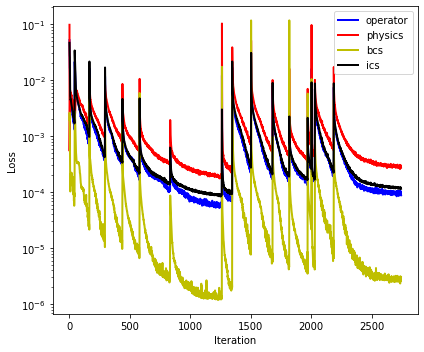

In [14]:
plt.figure(figsize = (6,5))
plt.plot(model.loss_operator_log, 'b-', lw=2, label='operator')
plt.plot(model.loss_physics_log, 'r-', lw=2, label='physics')
plt.plot(model.loss_bcs_log, 'y-', lw=2, label='bcs')
plt.plot(model.loss_ics_log, 'k-', lw=2, label='ics')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# Test on Single Sample

In [20]:
# Generate a Single Test Data
key = 23
s_test_ = S_test[key]
# key = random.PRNGKey(112312347)
# P_test = 100
Nx = m
Nt = 101
u_test, y_test, s_test = generate_one_test_data(key, s_test_, Nx, Nt)

# Predict
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)

# Generate an uniform mesh
x = jnp.linspace(0, 1, Nx)
t = jnp.linspace(0, 1, Nt)
XX, TT = jnp.meshgrid(x, t)

# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_true = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')
# S_true = s_test_


# compute_error(key, )
# # Compute the relative l2 ermor 
# error = jnp.linalg.norm(S_pred - S_true, 2) / jnp.linalg.norm(S_true, 2) 
# print('Relative l2 errpr: {:.3e}'.format(error))

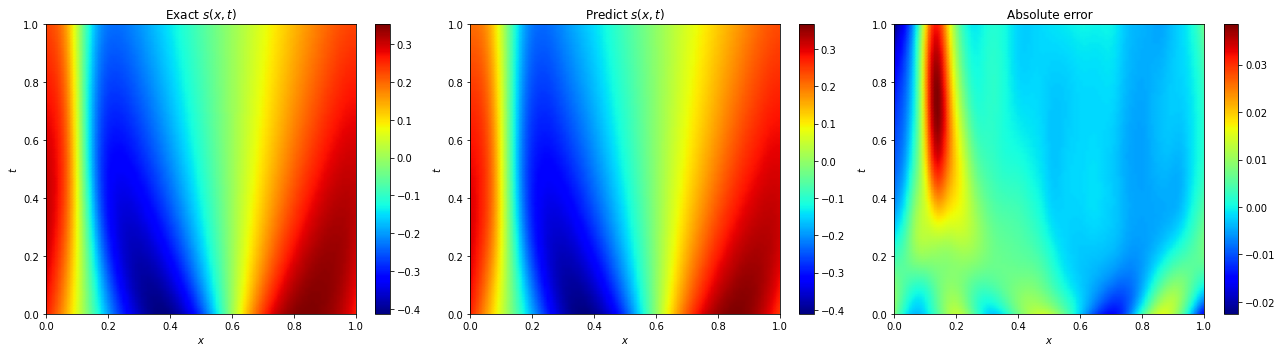

In [21]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(XX,TT, S_true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(XX,TT, S_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(XX,TT, S_pred - S_true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()